In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib

In [60]:
df = pd.read_csv('DatainBrief.csv')

# Clean column names: remove spaces, dashes, parentheses
df.columns = [c.strip().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '') 
              for c in df.columns]



In [61]:
# Quick peek
display(df.head())
display(df.info())

,Longitude,Latitude,Zip_Codes,Sold_Month,Days_on_Market,Original_List_Price,Listing_Price,Sold_Price,Taxes,Sold_Terms,...,High_School,HighRating,AirQuality,Walk_Score,TrailHikeDistance,WalkingPathDistance,PalygroundDistance,RecCenterDistance,Rest_Nearby,NearestGrocery
0,-85.275895,35.003498,37407,September,103.0,289900.0,249900.0,224900.0,526.14,FHA,...,Howard Academics,2.0,67.0,27.0,5.235838,0.211172,0.211172,0.408826,Level 5 (20 and above),5.903026
1,-85.214997,35.091343,37416,July,0.0,322000.0,322000.0,322000.0,1722.00,FHA,...,Central High School,4.0,67.0,8.0,2.647435,0.878386,1.474164,1.474164,Level 4 (16-19),7.021494
2,-85.171192,35.094263,37416,Jan,47.0,399500.0,399500.0,435000.0,392.64,FHA,...,Central High School,4.0,67.0,28.0,3.614487,1.658318,0.661948,0.661948,Level 4 (16-19),7.891414
3,-85.258671,35.023251,37411,Jan,1.0,250000.0,250000.0,250000.0,1808.38,Conv,...,East Ridge High,3.0,67.0,29.0,4.683885,0.654617,0.701705,1.603277,Level 4 (16-19),3.914639
4,-85.330598,34.998324,37409,April,1.0,430000.0,430000.0,435000.0,2972.84,Conv,...,Lookout Valley High,5.0,68.0,12.0,5.109016,0.734550,0.267914,0.734550,Level 4 (16-19),10.563310


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Longitude             872 non-null    float64
 1   Latitude              872 non-null    float64
 2   Zip_Codes             872 non-null    object 
 3   Sold_Month            872 non-null    object 
 4   Days_on_Market        872 non-null    float64
 5   Original_List_Price   872 non-null    float64
 6   Listing_Price         872 non-null    float64
 7   Sold_Price            873 non-null    float64
 8   Taxes                 871 non-null    float64
 9   Sold_Terms            872 non-null    object 
 10  SqFt___Total_Aprox    872 non-null    float64
 11  List_Price/SqFt       872 non-null    float64
 12  Sold_Price/SqFt       872 non-null    float64
 13  Basement              872 non-null    object 
 14  Year_Built            872 non-null    float64
 15  Aprx._Acres           8

None

In [62]:
# ========== 4. Convert numeric columns ==========
num_cols = ['Sold_Price', '#_Bedrooms', 'Baths___Total', 'SqFt___Total_Aprox', 'Year_Built',
            'AirQuality', 'Walk_Score', 'ElemRating', 'MiddleRating', 'HighRating', 
            'Original_List_Price', 'Listing_Price', 'Days_on_Market', 
            'Aprx__Acres', 'Taxes']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [63]:
# Drop rows with missing target
df = df[df['Sold_Price'].notna()]

In [64]:
# ========== 5. Feature Engineering ==========

# House age
df['House_Age'] = 2025 - df['Year_Built']

# Education: average of school ratings
df['Avg_School_Rating'] = df[['ElemRating', 'MiddleRating', 'HighRating']].mean(axis=1)

# --- Neighborhood Safety (Crime grades: convert A/B/C/D/F → numeric) ---

grade_map = {
    "A+": 5, "A": 4.7, "A-": 4.3,
    "B+": 4, "B": 3.7, "B-": 3.3,
    "C+": 3, "C": 2.7, "C-": 2.3,
    "D+": 2, "D": 1.7, "D-": 1.3,
    "F": 0
}

def convert_grade(grade_str):
    if pd.isna(grade_str):
        return None
    # Handle strings like "C-B-C-D+"
    parts = grade_str.replace("+", "+ ").replace("-", "- ").split()
    scores = [grade_map.get(p.strip(), None) for p in parts if p.strip() in grade_map]
    if scores:
        return sum(scores) / len(scores)
    return None

# Apply conversion to crime columns
for col in ["Overall_Crime_Grade", "Violent_Crime", "Property_Crime", "Other_Crime"]:
    df[col + "_Numeric"] = df[col].apply(convert_grade)

# Create average crime score
df["AvgCrimeScore"] = df[
    ["Overall_Crime_Grade_Numeric", "Violent_Crime_Numeric", "Property_Crime_Numeric", "Other_Crime_Numeric"]
].mean(axis=1)

# --- Green Living Features ---
distance_cols = ["TrailHikeDistance", "WalkingPathDistance", "PalygroundDistance", 
                 "RecCenterDistance", "NearestGrocery"]

df["AvgDistanceAmenity"] = df[distance_cols].mean(axis=1)

df["GreenLivingIndex"] = df[["AirQuality", "Walk_Score", "AvgDistanceAmenity"]].mean(axis=1)

# Quick check
print("New features added:", ["House_Age", "Avg_School_Rating", "AvgCrimeScore", "GreenLivingIndex"])


New features added: ['House_Age', 'Avg_School_Rating', 'AvgCrimeScore', 'GreenLivingIndex']


In [65]:
# ========== 6. Select features ==========
features = ['#_Bedrooms', 'Baths___Total', 'SqFt___Total_Aprox', 'House_Age',
            'Avg_School_Rating', 'AvgCrimeScore', 'GreenLivingIndex',
            'AirQuality', 'Walk_Score',
            'Original_List_Price', 'Listing_Price', 'Days_on_Market', 'Aprx._Acres', 'Taxes']

target = 'Sold_Price'

df_model = df[features + [target]].copy()



In [66]:
# ========== 6. Train/test split ==========
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [67]:
# ========== 7. Preprocessing + Model pipeline ==========
numeric_features = features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

In [68]:
# ==========  Log-transform target ==========
y_train = np.log1p(y_train)
y_test_log = np.log1p(y_test)  # Keep original y_test for final evaluation

In [69]:
# ==========  Preprocessing + Model pipeline ==========
numeric_features = features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, random_state=42))
])

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [70]:
# ========== 8. Train model ==========


In [71]:
# ==========  Predict & Evaluate ==========
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert back to original scale

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

MAE: 14,046.18
RMSE: 22,838.93
R²: 0.9839


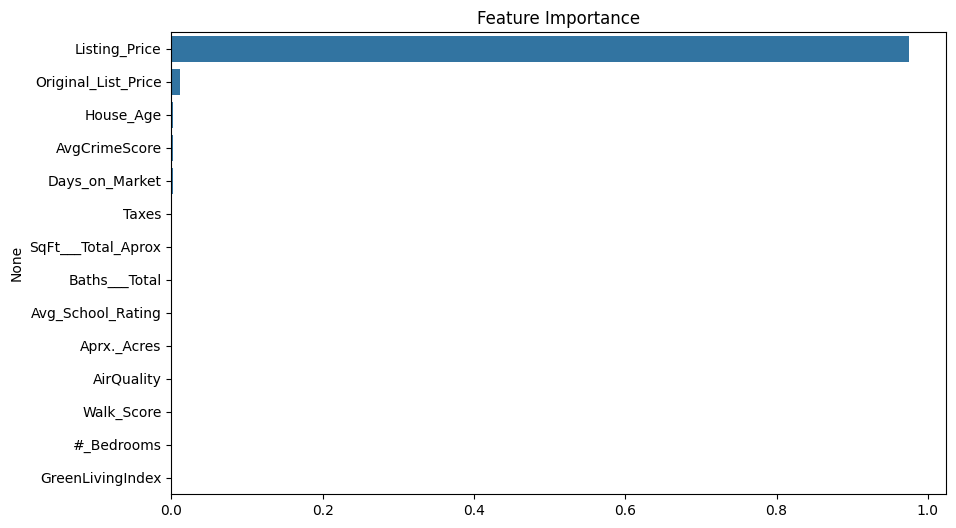

#_Bedrooms: 0.0005
Baths___Total: 0.0006
SqFt___Total_Aprox: 0.0007
House_Age: 0.0029
Avg_School_Rating: 0.0006
AvgCrimeScore: 0.0025
GreenLivingIndex: 0.0004
AirQuality: 0.0005
Walk_Score: 0.0005
Original_List_Price: 0.0115
Listing_Price: 0.9755
Days_on_Market: 0.0025
Aprx._Acres: 0.0005
Taxes: 0.0008


In [82]:
# ========== 12. Feature importance ==========
xgb_model = model.named_steps['regressor']
importance = xgb_model.feature_importances_
feat_importance = pd.Series(importance, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title('Feature Importance')
plt.show()
for feat, imp in zip(features, xgb_model.feature_importances_):
    print(f"{feat}: {imp:.4f}")

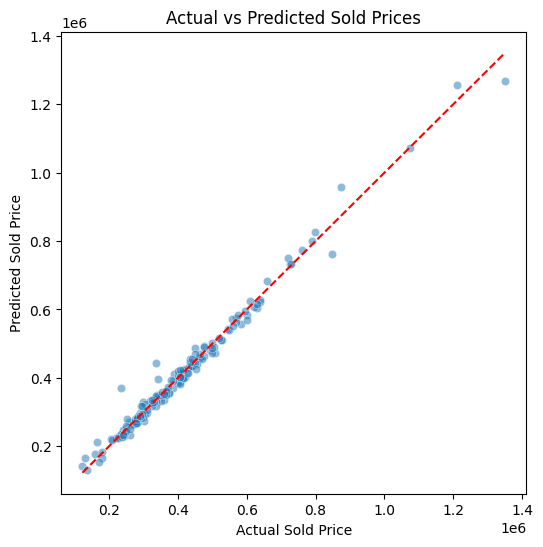

In [73]:
# ========== 13. Scatter plot: Actual vs Predicted ==========
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sold Price')
plt.ylabel('Predicted Sold Price')
plt.title('Actual vs Predicted Sold Prices')
plt.show()

In [74]:
# ========== 14. Save trained model ==========
joblib.dump(model, 'housing_price_model_strong_predictors.joblib')
print("Model saved as 'housing_price_model_strong_predictors.joblib'")

Model saved as 'housing_price_model_strong_predictors.joblib'


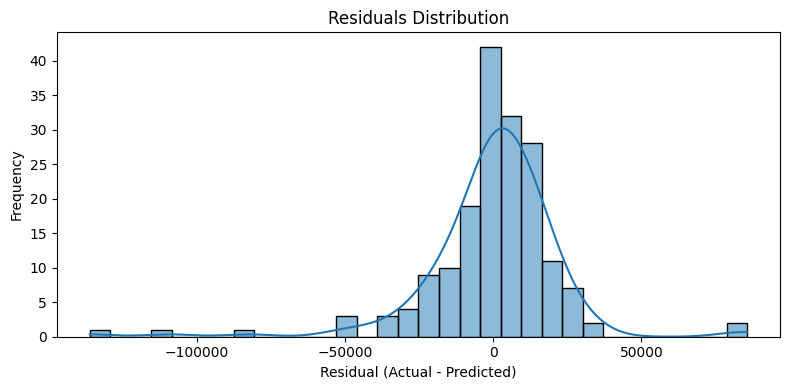

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



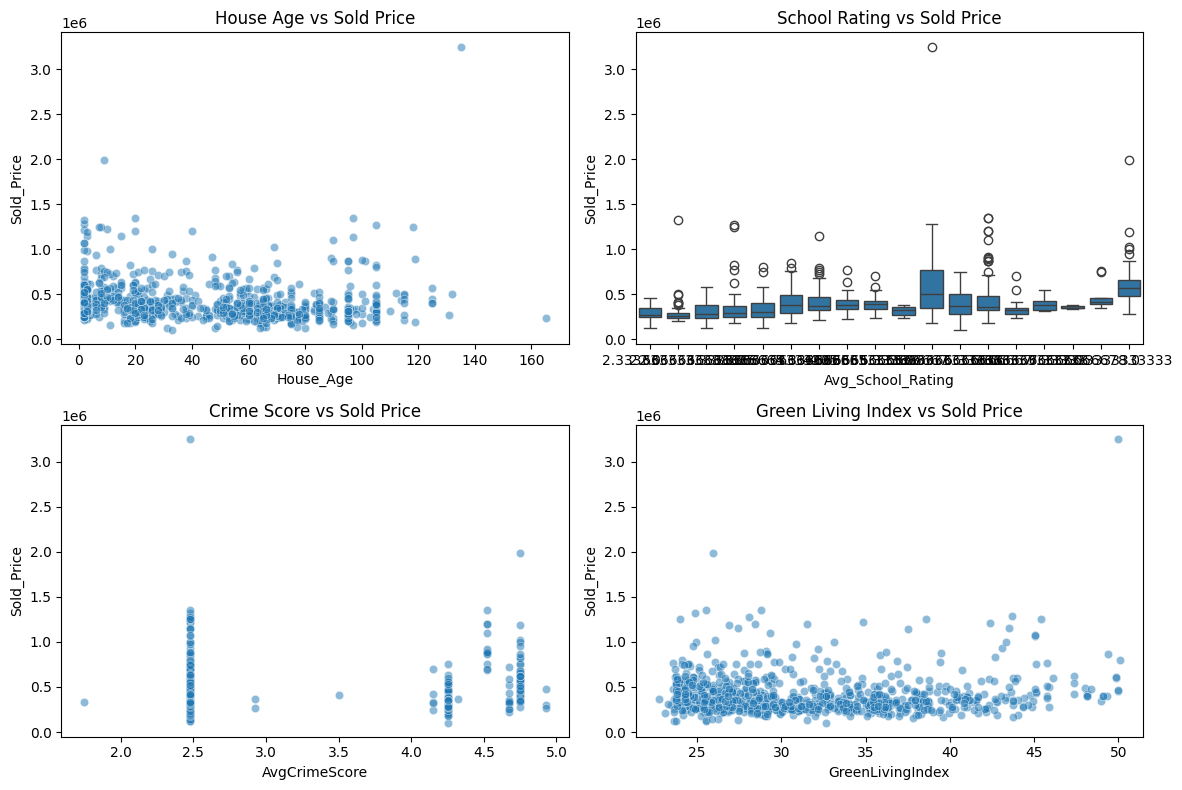

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.scatterplot(x=df['House_Age'], y=df['Sold_Price'], alpha=0.5, ax=axes[0,0])
axes[0,0].set_title("House Age vs Sold Price")

sns.boxplot(x=df['Avg_School_Rating'], y=df['Sold_Price'], ax=axes[0,1])
axes[0,1].set_title("School Rating vs Sold Price")

sns.scatterplot(x=df['AvgCrimeScore'], y=df['Sold_Price'], alpha=0.5, ax=axes[1,0])
axes[1,0].set_title("Crime Score vs Sold Price")

sns.scatterplot(x=df['GreenLivingIndex'], y=df['Sold_Price'], alpha=0.5, ax=axes[1,1])
axes[1,1].set_title("Green Living Index vs Sold Price")

plt.tight_layout()
plt.show()


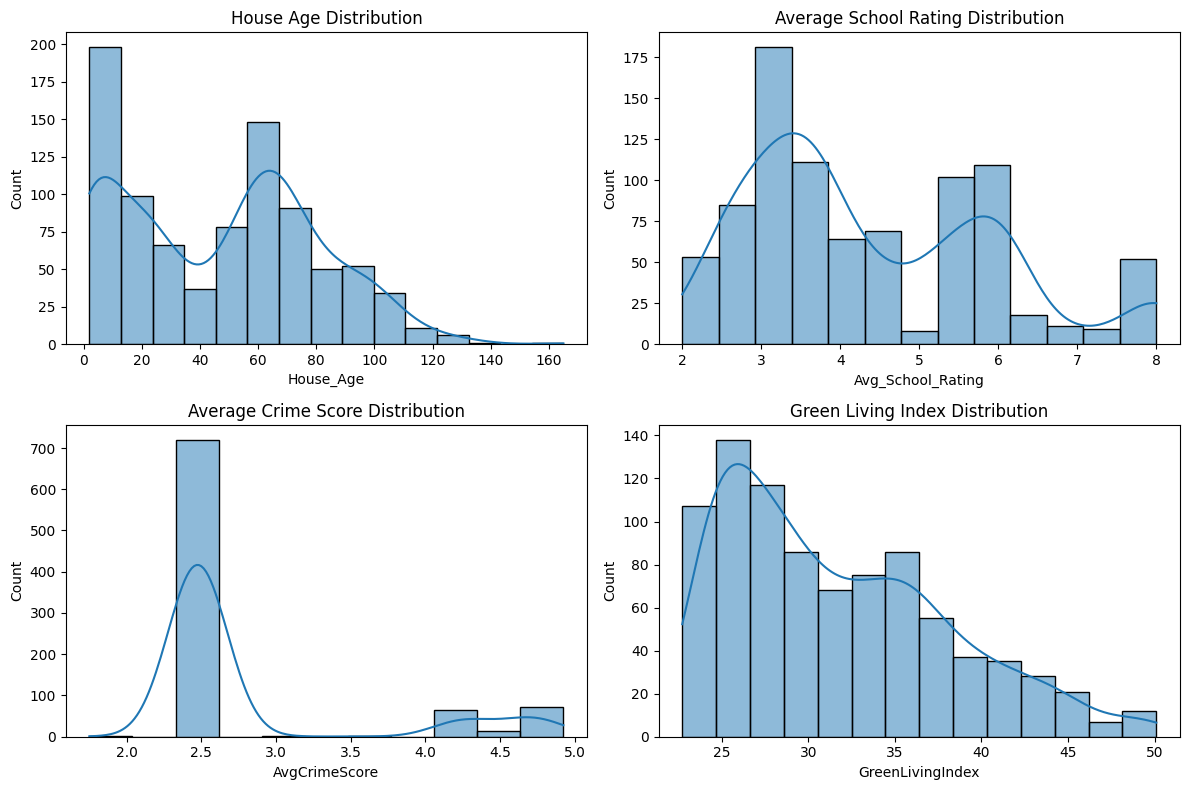

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.histplot(df['House_Age'], kde=True, ax=axes[0,0])
axes[0,0].set_title("House Age Distribution")

sns.histplot(df['Avg_School_Rating'], kde=True, ax=axes[0,1])
axes[0,1].set_title("Average School Rating Distribution")

sns.histplot(df['AvgCrimeScore'], kde=True, ax=axes[1,0])
axes[1,0].set_title("Average Crime Score Distribution")

sns.histplot(df['GreenLivingIndex'], kde=True, ax=axes[1,1])
axes[1,1].set_title("Green Living Index Distribution")

plt.tight_layout()
plt.show()


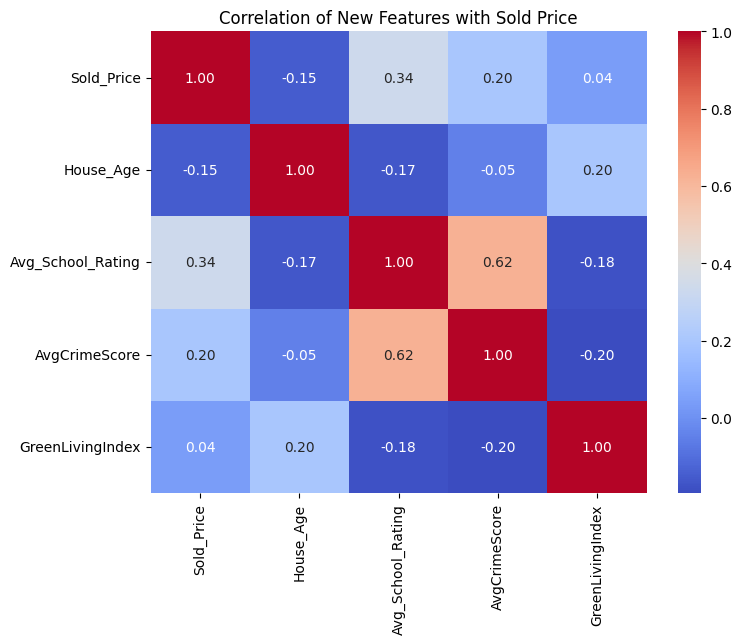

In [80]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Sold_Price', 'House_Age', 'Avg_School_Rating', 
                'AvgCrimeScore', 'GreenLivingIndex']].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of New Features with Sold Price")
plt.show()


#_Bedrooms: 0.0005
Baths___Total: 0.0006
SqFt___Total_Aprox: 0.0007
House_Age: 0.0029
Avg_School_Rating: 0.0006
AvgCrimeScore: 0.0025
GreenLivingIndex: 0.0004
AirQuality: 0.0005
Walk_Score: 0.0005
Original_List_Price: 0.0115
Listing_Price: 0.9755
Days_on_Market: 0.0025
Aprx._Acres: 0.0005
Taxes: 0.0008


In [77]:
S

NameError: name 'S' is not defined